# panGI: Explore Intracellular Signalling

Import required libraries

In [1]:
import os
import pandas as pd
import numpy as np

import decoupler as dc

import matplotlib.pyplot as plt
import plotnine as p9

import re
import glob

from scripts.plots import *
from scripts.utils import *

Load TF Prior Knowledge

In [ ]:
net = get_regulons(path=os.path.join("data", "collectri.csv"))

### Load data and define parameters

In [ ]:
groupby = 'cell_type'
stat = 'log2FoldChange'
padj_threshold = 0.05
logfc_threshold = 0.5
minimum_degs = 10

In [ ]:
# load cell type of interest from CCC
cell_pairs = pd.read_csv(os.path.join('results', "cell_pairs.csv"))
cell_types = np.union1d(cell_pairs["source"].unique(), cell_pairs["target"].unique())

Load & Concat DEA results

In [ ]:
# detect csv files with PSBULK and load them from data
psbulk_files = glob.glob("data/PSBULK*.csv")
psbulk_files = [f for f in psbulk_files if re.search("PSBULK", f)]

# use first word after PSBULK as key
psbulk_dict = {}
for f in psbulk_files:
    key = re.search("PSBULK_(\w+)", f).group(1)
    psbulk_dict[key] = pd.read_csv(f, index_col=0)

# concat all PSBULK dataframes, key to column called type
all_dea = pd.concat(psbulk_dict, axis=0, keys=psbulk_dict.keys(), names=["type"]).reset_index().drop(columns=["level_1"])
all_dea.set_index(['gene'], inplace=True)

# if type == 'All_celltypes' SI, else EXT
all_dea['type'] = all_dea['type'].apply(lambda x: 'SI' if x == 'All_celltypes' else 'EXT')
all_dea.loc[:, 'contrast'] = all_dea.apply(lambda x: f"{x['cell_type']} ({x['type']})", axis=1)

In [ ]:
all_dea.head()

,type,baseMean,log2FoldChange,lfcSE,pvalue,padj,cell_type,contrast
gene,,,,,,,,
A1CF,SI,25.559388,-0.042877,0.178317,0.654316,0.956203,BEST4_enterocyte_colonocyte,BEST4_enterocyte_colonocyte (SI)
AAAS,SI,3.430359,-0.037139,0.210440,0.444082,0.906794,BEST4_enterocyte_colonocyte,BEST4_enterocyte_colonocyte (SI)
AACS,SI,3.623399,0.041506,0.203491,0.517439,0.924283,BEST4_enterocyte_colonocyte,BEST4_enterocyte_colonocyte (SI)
AADAC,SI,14.081884,-0.013262,0.212255,0.741635,0.972822,BEST4_enterocyte_colonocyte,BEST4_enterocyte_colonocyte (SI)
AAGAB,SI,6.497781,-0.004807,0.200479,0.944172,0.991940,BEST4_enterocyte_colonocyte,BEST4_enterocyte_colonocyte (SI)


### Plot the number of genes that are differentially expressed in each contrast.

In [ ]:
# filter by padj_trheshold, and absolute log2fc > logfc_threshold
all_sig = all_dea.query(f"padj <= {padj_threshold} and abs(log2FoldChange) > {logfc_threshold}").copy()
all_sig['contrast'] = all_sig['contrast'].astype('category')
all_sig = all_sig.groupby(['contrast', 'cell_type']).size().reset_index(name='count').sort_values('count', ascending=False)
all_sig['log10_count'] = np.log10(all_sig['count'])

/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


In [ ]:
all_sig['target_in_ccc'] = all_sig['cell_type'].apply(lambda x: x in cell_types)

/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 1368 rows containing missing values.


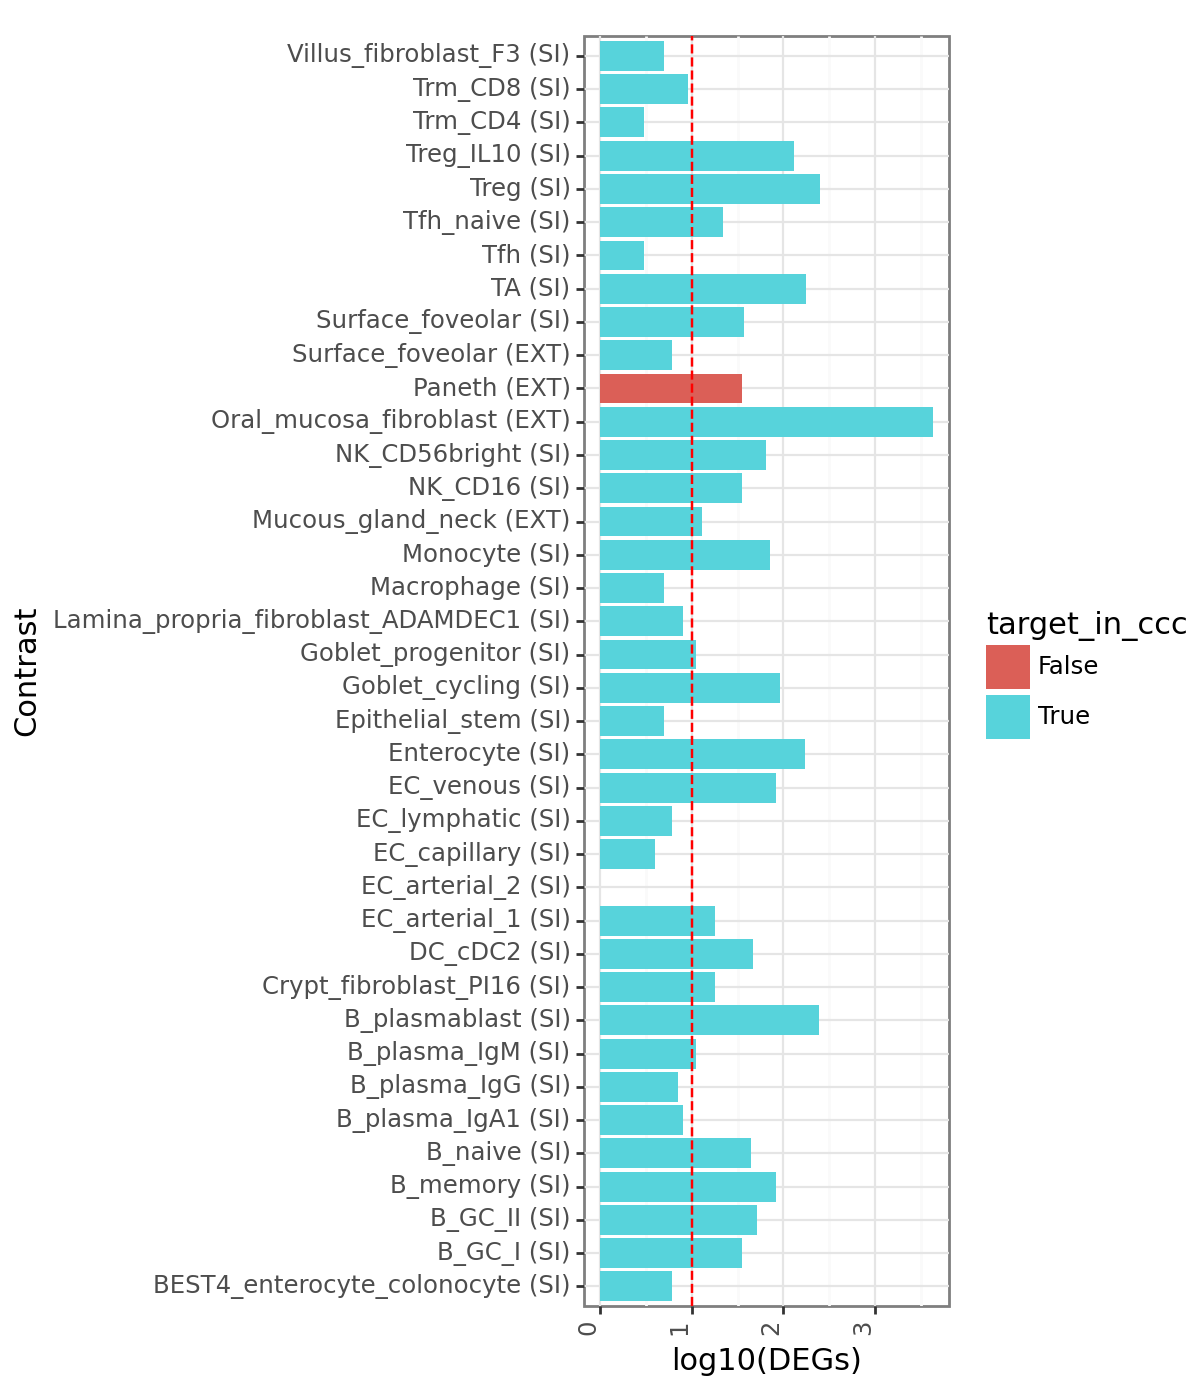

<Figure Size: (600 x 700)>

In [ ]:
# plot significant genes per cell type
# keep order of count
(p9.ggplot(all_sig, p9.aes(x='contrast', y='log10_count')) +
 # color code geom_bar by in_ccc
 p9.geom_bar(p9.aes(fill='target_in_ccc'), stat='identity') +
 p9.coord_flip() +
 p9.theme_bw() +
 p9.theme(axis_text_x=p9.element_text(angle=90, hjust=1), figure_size=(6, 7)) +
 p9.labs(x='Contrast', y='log10(DEGs)') + 
 # line at 10
 p9.geom_hline(yintercept=np.log10(minimum_degs), linetype='dashed', color='red')
 )

In [ ]:
# NOTE: we exclude SI and keep only EXT for cell types that are in both
# Though Foveolar work better for SI but I don't use them at all
ct_in_both = all_dea[['cell_type', 'type']].drop_duplicates().groupby('cell_type').count()
ct_in_both = ct_in_both[ct_in_both['type'] == 2].index

all_dea = all_dea.copy().reset_index()
anti = all_dea[(all_dea['cell_type'].isin(ct_in_both) & (all_dea['type'] == 'SI'))]
# anti join all_dea with anti
all_dea = all_dea.merge(anti, how='left', indicator=True)
all_dea = all_dea[all_dea['_merge'] == 'left_only'].drop(columns=['_merge'])
all_dea.set_index(['gene'], inplace=True)

In [ ]:
# NOTE: we save all dea here:
all_dea.to_csv(os.path.join('results', "dea_results.csv"))

### Define cell types of interest

In [ ]:
# add other cell types of interest to those from CCC
cell_types = list(cell_types) + ['Paneth']

### DEA Enrichment

In [ ]:
dea_df = all_dea[all_dea['cell_type'].isin(cell_types)]

In [ ]:
contrasts = all_sig[all_sig['count'] >= minimum_degs].sort_values('contrast')['contrast'].unique()
contrasts = list(contrasts) + ["Epithelial_stem (SI)"]

In [ ]:
# NOTE only contrasts with > mininum_degs DEGs + Epithelial Stem
dea_df = dea_df[dea_df['contrast'].isin(contrasts)]
# NOTE: we reduce cell types further to those from LR NMF
cell_types = np.intersect1d(cell_types, dea_df['cell_type'].unique())

Loop Over all Cell types

In [ ]:
ct_acts = {}

for cell_type in cell_types:
    ct_df = dea_df[dea_df[groupby] == cell_type].copy()
    # volcano plot
    dc.plot_volcano_df(ct_df, x='log2FoldChange', y='pvalue', top=20)
    plt.title(cell_type)
    plt.tight_layout()
    plt.savefig(os.path.join('figures', 'dea_vp', f"{cell_type}_volcano.pdf"))
    # plt.show()
    
    mat = ct_df[[stat]].T.rename(index={stat: cell_type})
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=net)
    
    # barplot
    dc.plot_barplot(tf_acts, cell_type, top=25, vertical=True)
    plt.title(cell_type)
    plt.tight_layout()
    plt.savefig(os.path.join('figures', 'tfs', f"{cell_type}_tf.pdf"))
    # plt.show()
    
    # append to the same dict
    tf_acts = tf_acts.T.rename(columns={cell_type: 'activity'})
    tf_pvals = tf_pvals.T.rename(columns={cell_type: 'pvalue'})
    tf_pvals['fdr'] = dc.p_adjust_fdr(tf_pvals['pvalue'])
    act = tf_acts.merge(tf_pvals, left_index=True, right_index=True)
    ct_acts[cell_type] = act
    
    # discard plt cache
    plt.close('all')

In [ ]:
acts_df = pd.concat(ct_acts).reset_index(names=['cell_type', 'tf'])

In [ ]:
acts_df.to_csv(os.path.join('results', "acts_df.csv"))